# Data Assimilation for Multiscale Systems (MSDA)

In this tutorial module we explore multiscale algorithms for ensemble DA. We use a simplified 2D vortex model for the purpose of demonstration, the ensemble square root filter (EnSRF), a deterministic variant of the EnKF, is chosen as the main filter update algorithm to perform DA. We will show how the model state is decomposed into several scale components and how to build a multiscale iterative process to update each component sequentially. We will play with model/filter parameters (number of scales, localization, inflation and observation quality) to demonstrate their behavior.

#Some preparation

## Define model state and dynamics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [2]:
##utility functions: convert between state and spectral spaces
##we only consider square domains in this case (ni=nj)
def grid2spec(f):
    ni, nj = (f.shape[0], f.shape[1])
    return np.fft.fft2(f, axes=(0, 1))

def spec2grid(fk):
    ni, nj = (fk.shape[0], fk.shape[1])
    return np.real(np.fft.ifft2(fk, axes=(0, 1)))

##generate wavenumber sequence for fft results
def fft_wn(n):
    nup = int(np.ceil((n+1)/2))
    if n%2 == 0:
        wn = np.concatenate((np.arange(0, nup), np.arange(2-nup, 0)))
    else:
        wn = np.concatenate((np.arange(0, nup), np.arange(1-nup, 0)))
    return wn

##generate meshgrid wavenumber for input field x
## the first two dimensions are horizontal (i, j)
def get_wn(x):
    dims = x.shape
    n = dims[0]
    wn = fft_wn(dims[0])
    rp_dims = tuple(np.delete(np.arange(len(dims)), 0))
    wni = np.expand_dims(wn, rp_dims)
    for d in rp_dims:
        wni = np.repeat(wni, dims[d], axis=d)
    rp_dims = tuple(np.delete(np.arange(len(dims)), 1))
    wnj = np.expand_dims(wn, rp_dims)
    for d in rp_dims:
        wnj = np.repeat(wnj, dims[d], axis=d)
    return wni, wnj

##scaled wavenumber k for pseudospectral method
def get_scaled_wn(x, dx):
    n = x.shape[0]
    wni, wnj = get_wn(x)
    ki = (2.*np.pi) * wni / (n*dx)
    kj = (2.*np.pi) * wnj / (n*dx)
    return ki, kj

In [3]:
##random realization of model initial condition
##amp: wind speed amplitude; power_law: wind field power spectrum slope
def gen_random_flow(ni, nj, nv, dx, amp, power_law):
    x = np.zeros((ni, nj, nv))
    ##generate random streamfunction for the wind
    psi = random_field(ni, power_law-2)
    ##convert to wind
    u = -(np.roll(psi, -1, axis=1) - np.roll(psi, 1, axis=1)) / (2.0*dx)
    v = (np.roll(psi, -1, axis=0) - np.roll(psi, 1, axis=0)) / (2.0*dx)
    ##normalize and scale to required amp
    u = amp * (u - np.mean(u)) / np.std(u)
    v = amp * (v - np.mean(v)) / np.std(v)
    x[:, :, 0] = u
    x[:, :, 1] = v
    return x

##rankine vortex. Vmax: maximum wind speed, Rmw: radius of max wind, loc_sprd: the spread in center location
def gen_vortex(ni, nj, nv, Vmax, Rmw, loc_sprd):
    x = np.zeros((ni, nj, nv))
    ii, jj = np.mgrid[0:ni, 0:nj]
    center_i = 0.5*ni+np.random.normal(0, loc_sprd)
    center_j = 0.5*nj+np.random.normal(0, loc_sprd)
    dist = np.sqrt((ii-center_i)**2 + (jj-center_j)**2)
    dist[np.where(dist==0)] = 1e-10  ##avoid divide by 0
    wspd = np.zeros(dist.shape)
    ind = np.where(dist <= Rmw)
    wspd[ind] = Vmax * dist[ind] / Rmw
    ind = np.where(dist > Rmw)
    wspd[ind] = Vmax * (Rmw / dist[ind])**1.5
    wspd[np.where(dist==0)] = 0
    x[:, :, 0] = -wspd * (jj - center_j) / dist  ##u component
    x[:, :, 1] = wspd * (ii - center_i) / dist   ##v component
    return x

def random_field(n, power_law):
    pk = lambda k: k**((power_law-1)/2)
    wn = fft_wn(n)
    kx, ky = np.meshgrid(wn, wn)
    k2d = np.sqrt(kx**2 + ky**2)
    k2d[np.where(k2d==0.0)] = 1e-10
    noise = np.fft.fft2(np.random.normal(0, 1, (n, n)))
    amplitude = pk(k2d)
    amplitude[np.where(k2d==1e-10)] = 0.0
    noise1 = np.real(np.fft.ifft2(noise * amplitude))
    return (noise1 - np.mean(noise1))/np.std(noise1)

In [4]:
##model forecast step:
def advance_time(X, dx, dt, smalldt, gen, diss):
    ##input wind components, convert to spectral space
    u = grid2spec(X[:, :, 0])
    v = grid2spec(X[:, :, 1])
    ##convert to zeta
    ki, kj = get_scaled_wn(u, dx)
    zeta = 1j * (ki*v - kj*u)
    k2 = ki**2 + kj**2
    k2[np.where(k2==0)] = 1  #avoid singularity in inversion
    ##run time loop:
    for n in range(int(dt/smalldt)):
        ##use rk4 numeric scheme to integrate forward in time:
        rhs1 = forcing(u, v, zeta, dx, gen, diss)
        zeta1 = zeta + 0.5*smalldt*rhs1
        rhs2 = forcing(u, v, zeta1, dx, gen, diss)
        zeta2 = zeta + 0.5*smalldt*rhs2
        rhs3 = forcing(u, v, zeta2, dx, gen, diss)
        zeta3 = zeta + smalldt*rhs3
        rhs4 = forcing(u, v, zeta3, dx, gen, diss)
        zeta = zeta + smalldt*(rhs1/6.0 + rhs2/3.0 + rhs3/3.0 + rhs4/6.0)
        ##inverse zeta to get u, v
        psi = -zeta / k2
        u = -1j * kj * psi
        v = 1j * ki * psi
    X1 = X.copy()
    X1[:, :, 0] = spec2grid(u)
    X1[:, :, 1] = spec2grid(v)
    return X1

def forcing(u, v, zeta, dx, gen, diss):
    ki, kj = get_scaled_wn(zeta, dx)
    ug = spec2grid(u)
    vg = spec2grid(v)
    ##advection term:
    f = -grid2spec(ug*spec2grid(1j*ki*zeta) + vg*spec2grid(1j*kj*zeta))
    ##generation term:
    vmax = np.max(np.sqrt(ug**2+vg**2))
    if vmax > 75:  ##cut off generation if vortex intensity exceeds limit
        gen = 0
    n = zeta.shape[0]
    k2d = np.sqrt(ki**2 + kj**2)*(n*dx)/(2.*np.pi)
    kc = 8
    dk = 3
    gen_response = np.exp(-0.5*(k2d-kc)**2/dk**2)
    f += gen*gen_response*zeta
    ##dissipation term:
    f -= diss*(ki**2+kj**2)*zeta
    return f

## Define observation network

In [5]:
def gen_obs_loc(ni, nj, nv, nobs):
    Yloc2 = np.zeros((2, nobs))
    Yloc2[0, :] = np.random.uniform(0, ni, nobs)
    Yloc2[1, :] = np.random.uniform(0, nj, nobs)
    Yloc = np.zeros((3, nobs*nv))
    for k in range(nv):
        Yloc[0:2, k::nv] = Yloc2
        Yloc[2, k::nv] = k
    return Yloc

def obs_interp2d(X, Yloc):
    dims = X.shape
    ni, nj = (dims[0], dims[1])
    io = Yloc[0, :]
    jo = Yloc[1, :]
    vo = Yloc[2, :].astype(int)
    io1 = np.floor(io).astype(int) % ni
    jo1 = np.floor(jo).astype(int) % nj
    io2 = np.floor(io+1).astype(int) % ni
    jo2 = np.floor(jo+1).astype(int) % nj
    di = io - np.floor(io)
    dj = jo - np.floor(jo)
    Y = (1-di)*(1-dj)*X[io1, jo1, vo] + di*(1-dj)*X[io2, jo1, vo] + (1-di)*dj*X[io1, jo2, vo] + di*dj*X[io2, jo2, vo]
    return Y

def plot_obs(ax, ni, nj, nv, Y, Ymask, Yloc):
    obsmin, obsmax = (-30, 30)
    cmap = [plt.cm.bwr(x) for x in np.linspace(0, 1, round(obsmax-obsmin)+1)]
    subset = np.where(np.logical_and(Yloc[2, :]==0, Ymask==1))
    color_ind = np.maximum(np.minimum(np.round(Y[subset]-obsmin), int(round(obsmax-obsmin))), 0).astype(int)
    ax.scatter(Yloc[0, subset], Yloc[1, subset], s=30, color=np.array(cmap)[color_ind, 0:3])
    ax.set_xlim([0, ni])
    ax.set_ylim([0, nj])
    return

## Scale decomposition

In [78]:
###Pyramid method for spatial fields
###resolution level 1 correspond to the original field ni*nj, top-level has 2*2 grid points 2**lev=ni

##generate location coordinates (i, j, k) for each grid point
def get_loc(ni, nj, nv, lev):
    intv = 2 ** (lev-1)
    ii, jj, kk = np.mgrid[0:ni:intv, 0:nj:intv, 0:nv]
    Xloc = np.zeros((3, int(ni/intv), int(nj/intv), nv))
    Xloc[0, :, :, :] = ii
    Xloc[1, :, :, :] = jj
    Xloc[2, :, :, :] = kk
    return Xloc

def get_clev(wn):
    lev = 5 - np.log(wn)/np.log(2)
    return lev

def get_nobs_thin(wn, ni, nj, nobs):
    oclev = np.sqrt(ni*nj/nobs)
    clev = get_clev(wn)
    if clev<oclev:
        print("this scale is not resolved by obs")
        thin = 1
    else:
        thin = 2**(2*(clev - oclev))
    return int(nobs/thin)


###Weighted running avg equivalent to a bandpass filter (according to convolution theorem)
###or just use spectral bandpass filter in spec space
def get_scale(x, kr, s):
    xk = grid2spec(x)
    xkout = xk.copy()
    ns = len(kr)
    if ns > 1:
        kx, ky = get_wn(x)
        Kh = np.sqrt(kx**2 + ky**2)
        if s == 0:
            xkout = xk * lowpass_resp(Kh, kr[s], kr[s+1])
        if s == ns-1:
            xkout = xk * (1 - lowpass_resp(Kh, kr[s-1], kr[s]))
        if s > 0 and s < ns-1:
            xkout = xk * (lowpass_resp(Kh, kr[s], kr[s+1]) - lowpass_resp(Kh, kr[s-1], kr[s]))
    return spec2grid(xkout)

def obs_get_scale(ni, nj, nv, Y, Ymask, Yloc, kr, s):
    Ys = Y.copy()
    nobs = Y.size
    ns = len(kr)
    if ns > 1:
        x = np.zeros((ni, nj, nv))
        kx, ky = get_wn(x)
        Kh = np.sqrt(kx**2 + ky**2)
        if s == 0:
            Ys = obs_convol(ni, nj, Y, Ymask, Yloc, spec2grid(lowpass_resp(Kh, kr[s], kr[s+1]))*ni*nj*nv/nobs)
        if s == ns-1:
            Ys = Y - obs_convol(ni, nj, Y, Ymask, Yloc, spec2grid(lowpass_resp(Kh, kr[s-1], kr[s]))*ni*nj*nv/nobs)
        if s > 0 and s < ns-1:
            Ys = obs_convol(ni, nj, Y, Ymask, Yloc, spec2grid(lowpass_resp(Kh, kr[s], kr[s+1]))*ni*nj*nv/nobs)
            Ys -= obs_convol(ni, nj, Y, Ymask, Yloc, spec2grid(lowpass_resp(Kh, kr[s-1], kr[s]))*ni*nj*nv/nobs)
    return Ys

def obs_convol(ni, nj, Y, Ymask, Yloc, r):
    Yout = np.zeros(Y.shape)
    for n in range(Y.size):
        if Ymask[n] == 1:
            dloc = np.zeros(Yloc.shape)
            dloc[0, :] = np.minimum(np.abs(Yloc[0, :]-Yloc[0, n]),ni-np.abs(Yloc[0, :]-Yloc[0, n]))
            dloc[1, :] = np.minimum(np.abs(Yloc[1, :]-Yloc[1, n]),nj-np.abs(Yloc[1, :]-Yloc[1, n]))
            dloc[2, :] = Yloc[2, :]
            w = obs_interp2d(r, dloc)
            w[np.where(Yloc[2, :]!=Yloc[2, n])] = 0.0
            Yout[n] = np.sum(w*Y)
    return Yout

def lowpass_resp(Kh, k1, k2):
    r = np.zeros(Kh.shape)
    r[np.where(Kh<k1)] = 1.0
    r[np.where(Kh>k2)] = 0.0
    ind = np.where(np.logical_and(Kh>=k1, Kh<=k2))
    r[ind] = np.cos((Kh[ind] - k1)*(0.5*np.pi/(k2 - k1)))**2
    return r


In [7]:
###define scale band wavenumbers given dimensions
def get_krange(ns):
    kmax = 16 ##determined by vortex size: smallest feature scale
    dk = kmax**(1/ns)
    krange = dk**(np.arange(ns)+1)
    return krange

def get_krange_obs(ns, ni, nj, nobs):
    kmax = 16, 
    dk = kmax**(1/ns)
    krange = dk**(np.arange(ns)+1)
    return krange

def get_obs_err_scale(ni, nj, nv, nobs, krange, s):
    Y = np.zeros(nobs*nv)
    Ymask = np.zeros(nobs*nv)
    Y[0] = 1.0
    Ymask[0] = 1
    Yloc = gen_obs_loc(ni, nj, nv, nobs)
    Ys = obs_get_scale(ni, nj, nv, Y, Ymask, Yloc, krange, s)
    obs_err_scale = Ys[0]
    return obs_err_scale

## Ensemble filter update algorithms

In [95]:
##top-level wrapper for update at one analysis cycle:
def filter_update(Xb, Yo, Ymask, Yloc, filter_kind, obs_err_std, local_cutoff, 
                  krange, krange_obs, run_alignment, print_out=False):
    X = Xb.copy()
    ni, nj, nv, nens = Xb.shape
    nobs = Yo.size
    ns = len(krange)
    ns_obs = len(krange_obs)

    for s in range(ns):
        print('   process scale component {}'.format(s+1))
        ##get scale component for prior state
        clev = int(get_clev(krange[s]))
        Xbs = coarsen(get_scale(X, krange, s), 1, clev)
        Xloc = get_loc(ni, nj, nv, clev)

        Xas = Xbs.copy()
        for r in range(ns_obs):
            ##get scale component for obs
            Yos = obs_get_scale(ni, nj, nv, Yo, Ymask, Yloc, krange_obs, r)
            ##get scale component for obs prior
            Ybs = np.zeros((nobs, nens))
            for m in range(nens):
                Ybm = obs_interp2d(X[:, :, :, m], Yloc)
                Ybm[np.where(Ymask==0)] = 0.0
                Ybs[:, m] = obs_get_scale(ni, nj, nv, Ybm, Ymask, Yloc, krange_obs, r)
            obs_err_scale = get_obs_err_scale(ni, nj, nv, nobs, krange_obs, r)

            if filter_kind=='EnSRF':
                nobs1 = get_nobs_thin(krange_obs[r], ni, nj, nobs)
                Xas = EnSRF(Xas, Xloc, Ybs[0:nobs1], Yos[0:nobs1], Ymask[0:nobs1], Yloc[:, 0:nobs1], 
                            obs_err_std[s]*obs_err_scale, local_cutoff[s], print_out)
            
        if s < ns-1 and run_alignment:
            print('      run alignment')
            us, vs = optical_flow(Xbs, Xas, nlevel=6-clev, w=0.6)
            Xbsw = warp(Xbs, -us, -vs)
            u = refine(us * 2**(clev-1), clev, 1)
            v = refine(vs * 2**(clev-1), clev, 1)
            X = warp(X, -u, -v)  ##displacement adjustment
            X += refine(Xas - Xbsw, clev, 1)  ##additional amplitude adjustment
        else:
            X += refine(Xas - Xbs, clev, 1)

    return X

In [9]:
##EnSRF filter update:
def EnSRF(Xb, Xloc, Yb, Yo, Ymask, Yloc, obs_err_std, local_cutoff, print_out):
    ni, nj, nv, nens = Xb.shape
    nobs = Yo.size
    X = Xb.copy()
    Y = Yb.copy()
    for p in range(0, nobs):    ##cycle through each observation
        if Ymask[p] == 1:
            Xm = np.mean(X, axis=3)
            Xp = X - np.repeat(np.expand_dims(Xm, 3), nens, axis=3)
            Ym = np.mean(Y, axis=1)
            Yp = Y - np.repeat(np.expand_dims(Ym, 1), nens, axis=1)
            yo = Yo[p]
            yb_ens = Y[p, :]
            yb_mean = np.mean(yb_ens)
            ybp = yb_ens - yb_mean
            innov = yo - yb_mean
            varo = obs_err_std**2    ##obs error variance
            varb = np.sum(ybp**2) / (nens - 1)    ##prior error variance
            srf = 1.0 / (1.0 + np.sqrt(varo / (varo + varb)))    ##square root modification
            if print_out: ##print out obs info
                print(('u', 'v')[int(Yloc[2, p])] + ' obs at ({:4.1f}, {:4.1f}) '.format(Yloc[0, p], Yloc[1, p]) +
                    'yo={:5.2f} yo_var={:5.2f}, yb_mean={:5.2f}, yb_var={:5.2f}'.format(yo, varo, yb_mean, varb))
            if varb>0 and np.abs(innov)!=0:
                ##localization
                dist = get_dist(ni, nj, Xloc[0, :, :, :], Xloc[1, :, :, :], Yloc[0, p], Yloc[1, p])
                C = local_GC(dist, local_cutoff)
                ##Kalman gain
                gain = C * np.sum(Xp * np.tile(ybp, (ni, nj, nv, 1)), axis=3) / (nens - 1) / (varo + varb)
                ##update mean and perturbations
                Xm = Xm + gain * innov
                for m in range(nens):
                    Xp[:, :, :, m] = Xp[:, :, :, m] - srf * gain * ybp[m]
                X = Xp + np.repeat(np.expand_dims(Xm, 3), nens, axis=3)

                ##update observation priors
                dist1 = get_dist(ni, nj, Yloc[0, :], Yloc[1, :], Yloc[0, p], Yloc[1, p])
                C1 = local_GC(dist1, local_cutoff)
                gain1 = C1 * np.sum(Yp * np.tile(ybp, (nobs, 1)), axis=1) / (nens - 1) / (varo + varb)
                Ym = Ym + gain1 * innov
                for m in range(nens):
                    Yp[:, m] = Yp[:, m] - srf * gain1 * ybp[m]
                Y = Yp + np.repeat(np.expand_dims(Ym, 1), nens, axis=1)
    return X

##generate distance function (cyclic BC)
def get_dist(ni, nj, ii, jj, io, jo):
    dist = np.sqrt(np.minimum(np.abs(ii-io),ni-np.abs(ii-io))**2+np.minimum(np.abs(jj-jo),nj-np.abs(jj-jo))**2)
    return dist


def local_GC(dist, cutoff):
    loc = np.zeros(dist.shape)
    if cutoff>0:
        r = dist / (cutoff / 2)
        loc1 = (((-0.25*r + 0.5)*r + 0.625)*r - 5.0/3.0) * r**2 + 1
        ind1 = np.where(dist<cutoff/2)
        loc[ind1] = loc1[ind1]
        r[np.where(r==0)] = 1e-10
        loc2 = ((((r/12.0 - 0.5)*r + 0.625)*r + 5.0/3.0)*r - 5.0)*r + 4 - 2.0/(3.0*r)
        ind2 = np.where(np.logical_and(dist>=cutoff/2, dist<cutoff))
        loc[ind2] = loc2[ind2]
    else:
        loc = np.ones(dist.shape)
    return loc


In [90]:
###optical flow algorithm for alignment step:
###TODO: weight can be fixed if inputs are normalized
def optical_flow(x1in, x2in, nlevel, w=100):
    x1 = x1in.copy()
    x2 = x2in.copy()
    ni, nj, nv, nens = x1.shape
    ##normalize input fields
    for m in range(nens):
        for k in range(nv):
            xmax, xmin = (np.max(x1[:, :, k, m]), np.min(x1[:, :, k, m]))
            if xmax>xmin:
                x1[:, :, k, m] = (x1[:, :, k, m] - xmin) / (xmax - xmin)
                x2[:, :, k, m] = (x2[:, :, k, m] - xmin) / (xmax - xmin)
    u = np.zeros((ni, nj, nv, nens))
    v = np.zeros((ni, nj, nv, nens))
    ###pyramid levels
    for lev in range(nlevel, -1, -1):
        x1w = warp(x1, -u, -v)
        x1c = coarsen(x1w, 1, lev)
        x2c = coarsen(x2, 1, lev)
        niter = 1000
        xdx = 0.5*(deriv_x(x1c) + deriv_x(x2c))
        xdy = 0.5*(deriv_y(x1c) + deriv_y(x2c))  
        xdt = x2c - x1c
        ###compute incremental flow using iterative solver
        du = np.zeros(xdx.shape)
        dv = np.zeros(xdx.shape)
        for k in range(niter):
            ubar = laplacian(du) + du
            vbar = laplacian(dv) + dv
            du = ubar - xdx*(xdx*ubar + xdy*vbar + xdt)/(w + xdx**2 + xdy**2)
            dv = vbar - xdy*(xdx*ubar + xdy*vbar + xdt)/(w + xdx**2 + xdy**2)
        u += refine(du*2**(lev-1), lev, 1)
        v += refine(dv*2**(lev-1), lev, 1)
    return u, v

##coarsening resolution from lev1 to lev2 (lev1<lev2)
def coarsen(xi, lev1, lev2):
    x = xi.copy()
    if lev1 < lev2:
        for k in range(lev1, lev2):
            x1 = x[::2, ::2]
            x = x1
    return x

##increase resolution from lev1 to lev2, fill in grid points with linear interpolation
def refine(xi, lev1, lev2):
    x = xi.copy()
    if lev1 > lev2:
        for k in range(lev1, lev2, -1):
            dim = list(x.shape)
            dim[0] = dim[0]*2
            x1 = np.zeros(dim)
            x1[0:dim[0]:2, :] = x
            x1[1:dim[0]:2, :] = 0.5*(np.roll(x, -1, axis=0) + x)
            dim[1] = dim[1]*2
            x2 = np.zeros(dim)
            x2[:, 0:dim[1]:2] = x1
            x2[:, 1:dim[1]:2] = 0.5*(np.roll(x1, -1, axis=1) + x1)
            x = x2
    return x

def warp(x, u, v):
    xw = x.copy()
    ni, nj, nv, nens = x.shape
    ii, jj, vv, mm = np.mgrid[0:ni, 0:nj, 0:nv, 0:nens]
    xw = interp2d(x, ii+u, jj+v, vv, mm)
    return xw

def interp2d(x, io, jo, vv, mm):
    ni, nj, nv, nens = x.shape
    io1 = np.floor(io).astype(int) % ni
    jo1 = np.floor(jo).astype(int) % nj
    io2 = np.floor(io+1).astype(int) % ni
    jo2 = np.floor(jo+1).astype(int) % nj
    di = io - np.floor(io)
    dj = jo - np.floor(jo)
    xo = (1-di)*(1-dj)*x[io1, jo1, vv, mm] + di*(1-dj)*x[io2, jo1, vv, mm] + (1-di)*dj*x[io1, jo2, vv, mm] + di*dj*x[io2, jo2, vv, mm]
    return xo

##some spatial operators
def deriv_x(f):
    return (np.roll(f, -1, axis=0) - np.roll(f, 1, axis=0)) / 2.0

def deriv_y(f):
    return (np.roll(f, -1, axis=1) - np.roll(f, 1, axis=1)) / 2.0

def laplacian(f):
    return ((np.roll(f, -1, axis=0) + np.roll(f, 1, axis=0) + np.roll(f, -1, axis=1) + np.roll(f, 1, axis=1))/6. + 
            (np.roll(np.roll(f, -1, axis=1), -1, axis=0) + np.roll(np.roll(f, -1, axis=1), 1, axis=0) + 
             np.roll(np.roll(f, 1, axis=1), -1, axis=0) + np.roll(np.roll(f, 1, axis=1), 1, axis=0))/12. - f)


## Some diagnostic metrics

In [11]:
###some performance metrics
def rmse(Xens, Xt):
    return np.sqrt(np.mean((np.mean(Xens, axis=3)-Xt)**2, axis=(0,1,2)))

def sprd(Xens):
    return np.sqrt(np.mean(np.std(Xens, axis=3)**2, axis=(0,1,2)))

def sawtooth(out_b, out_a):
    nt = out_b.size
    tt = np.zeros(nt*2)
    tt[0::2] = np.arange(0, nt)
    tt[1::2] = np.arange(0, nt)
    out_st = np.zeros(nt*2)
    out_st[0::2] = out_b
    out_st[1::2] = out_a
    return tt, out_st

def pwr_spec(f):
    ni, nj, nv = f.shape
    fk = np.zeros((ni, nj, nv), dtype=complex)
    nupi = int(np.ceil((ni+1)/2))
    nupj = int(np.ceil((nj+1)/2))
    nup = max(nupi, nupj)
    wni = fft_wn(ni)
    wnj = fft_wn(nj)
    kj, ki = np.meshgrid(wni, wnj)
    k2d = np.sqrt((ki*(nup/nupi))**2 + (kj*(nup/nupj))**2)
    for v in range(nv):
        fk[:, :, v] = np.fft.fft2(f[:, :, v])
    P = (np.abs(fk)/ni/nj)**2
    Ptot = np.mean(P, axis=2)  ##kinetic energy is averaged u, v variances
    ##sum wavenumber ki and kj within range k2d=w
    wn = np.arange(0.0, nup)
    pwr = np.zeros(nup)
    for w in range(nup):
        pwr[w] = np.sum(Ptot[np.where(np.ceil(k2d)==w)])
    return wn, pwr

def err_spec(Xens, Xt):
    wn, err_pwr = pwr_spec(np.mean(Xens, axis=3)-Xt)
    return wn, err_pwr

def sprd_spec(Xens):
    ni, nj, nv, nens = Xens.shape
    Xmean = np.mean(Xens, axis=3)
    nup = int(np.ceil((ni+1)/2))
    pwr_ens = np.zeros((nup, nens))
    for m in range(nens):
        wn, pwr_ens[:, m] = pwr_spec(Xens[:, :, :, m] - Xmean)
    sprd_pwr = np.sum(pwr_ens, axis=1) / (nens-1)
    return wn, sprd_pwr

In [12]:
###some feature-space diagnostics
def vortex_center(X):
    u, v = (X[:, :, 0], X[:, :, 1])
    ni, nj = u.shape
    zeta = (np.roll(v, -1, axis=0) - np.roll(v, 1, axis=0) - np.roll(u, -1, axis=1) + np.roll(u, 1, axis=1))/2.0
    zmax = -999
    ic, jc = (-1, -1)
    buff = 2
    for i in range(buff, ni-buff):
        for j in range(buff, nj-buff):
            z = np.sum(zeta[i-buff:i+buff, j-buff:j+buff])
            if z > zmax:
                zmax = z
                ic, jc = (i, j)
    return np.array([ic, jc])

def vortex_intensity(X):
    u, v = (X[:, :, 0], X[:, :, 1])
    wind = np.sqrt(u**2+v**2)
    return np.max(wind)

def vortex_size(X, center):
    u, v = (X[:, :, 0], X[:, :, 1])
    ni, nj = u.shape
    nr = int(ni/4)
    wind_min = 30
    wind_rad = np.zeros(nr)
    count_rad = np.zeros(nr)
    wind = np.sqrt(u**2+v**2)
    for i in range(-nr, nr+1):
        for j in range(-nr, nr+1):
            r = int(np.sqrt(i**2+j**2))
            if (r<nr):
                wind_rad[r] += wind[int(center[0]+i)%ni, int(center[1]+j)%nj]
                count_rad[r] += 1
    wind_rad = wind_rad / count_rad
    wind_max = np.max(wind_rad)
    for r in range(nr):
        if (wind_rad[r] == wind_max):
            rmw = r 
    size = 0 
    for r in range(rmw, nr):
        if (wind_rad[r] <= wind_min):
            size = r 
            break    
    return size

#Visualize state and spectral space

In [41]:
print(get_krange(5, ni, nj, nobs))

[ 1.74110113  3.03143313  5.27803164  9.18958684 16.        ]


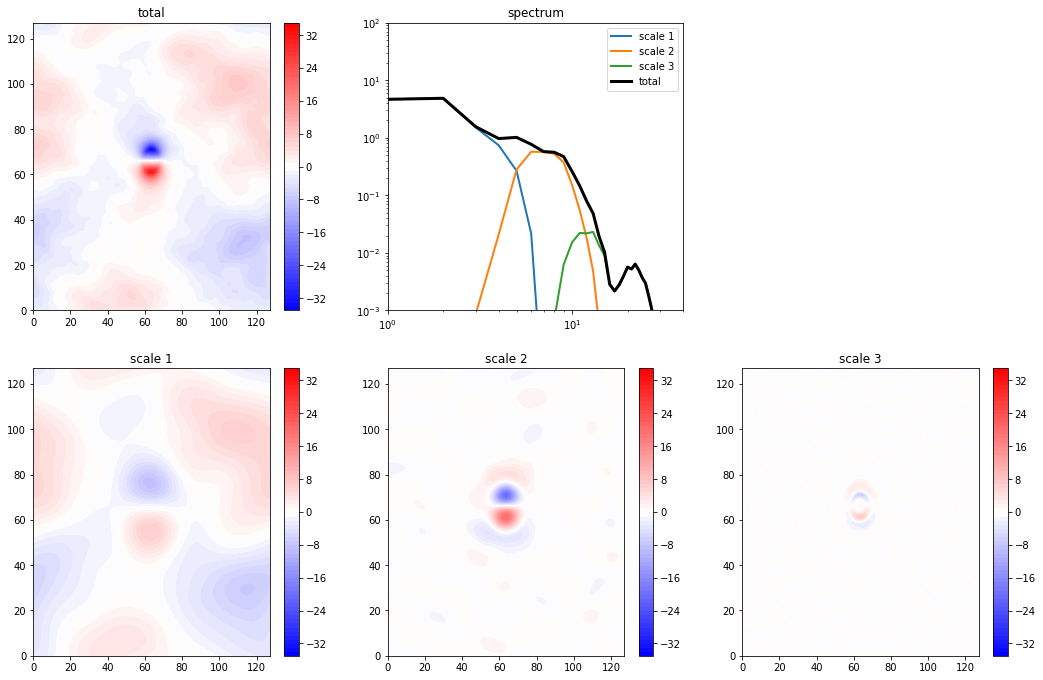

In [61]:
np.random.seed(1000)
dx = 9000
Xout = Xt[:, :, :, 1] #gen_vortex(ni, nj, nv, 35, 5, 0) + gen_random_flow(128, 128, 2, dx, 3, -3)

ni, nj, nv = Xout.shape
ns = 3
Xsc = np.zeros((ni, nj, nv, ns))

plt.figure(figsize=(18,18))
ax = plt.subplot(3,3,1)
c = ax.contourf(Xout[:, :, 0].T, np.arange(-35, 36), cmap='bwr')
plt.colorbar(c)
ax.set_title('total')
ax1 = plt.subplot(3,3,2)
for s in range(ns):
    Xs = get_scale(Xout, get_krange(ns, ni, nj, nobs), s)
    wn, pwr = pwr_spec(Xs)
    ax = plt.subplot(3,3,s+4)
    c = ax.contourf(Xs[:, :, 0].T, np.arange(-35, 36), cmap='bwr')
    plt.colorbar(c)
    ax.set_title('scale {}'.format(s+1))
    ax1.loglog(wn, pwr, linewidth=2, label='scale {}'.format(s+1))
wn, pwr = pwr_spec(Xout)
ax1.loglog(wn, pwr, color='black', linewidth=3, label='total')
ax1.set_xlim([1, 40])
ax1.set_ylim([1e-3, 1e2])
ax1.set_title('spectrum')
ax1.legend()


avail obs num =  1000.0


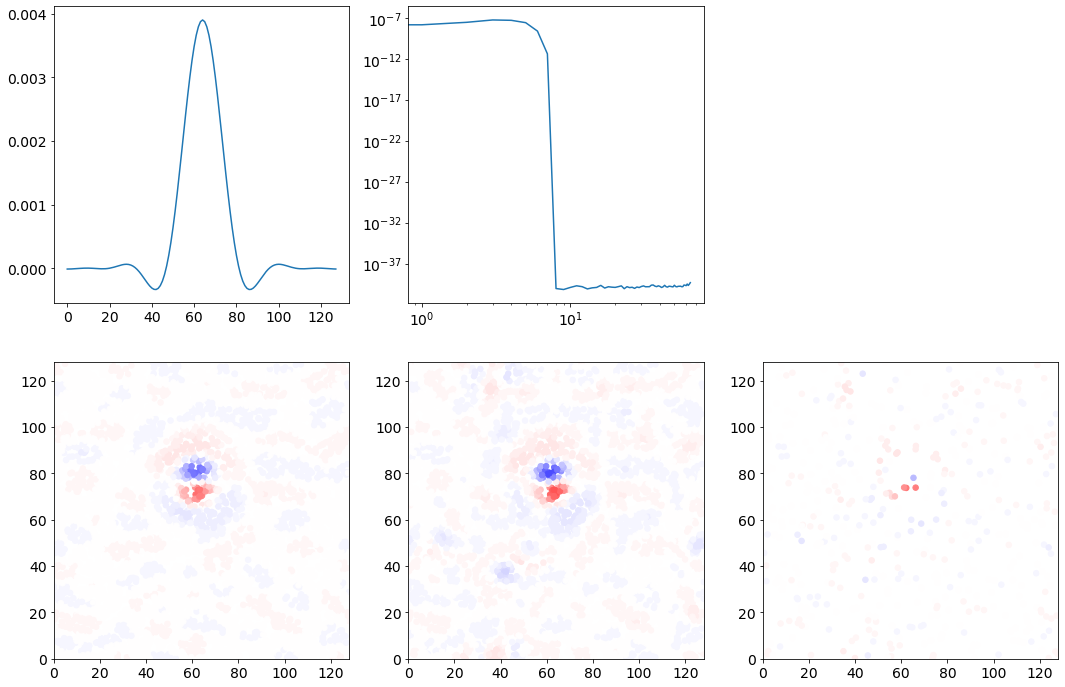

In [100]:
Xout = Xb[:, :, :, 10, 0]

nobs = 5000 #int(ni*nj/4)
obs_range = 300
krange = get_krange(3, ni, nj, nobs)
s = 1
ii, jj = np.mgrid[0:ni, 0:nj]

np.random.seed(0)
Yloc = gen_obs_loc(ni, nj, nv, nobs)

Ydist = np.sqrt((Yloc[0, :]-64)**2 + (Yloc[1, :]-64)**2)
Ymask = np.zeros(nobs*nv)
Ymask[np.where(Ydist<=obs_range)] = 1

kx, ky = get_wn(Xout)
kh = np.sqrt(kx**2 + ky**2)
rh = lowpass_resp(kh, krange[0], krange[1])
r = spec2grid(rh)
wn, pwr = pwr_spec(r)

plt.figure(figsize=(18,12))
ax = plt.subplot(2,3,1)
c = ax.plot(np.roll(r[:, 0, 0], 64))
#plt.colorbar(c)
ax = plt.subplot(2,3,2)
ax.loglog(wn, pwr)

X1 = get_scale(Xout, krange, s)
Y1 = obs_interp2d(X1, Yloc)

Yout = obs_interp2d(Xout, Yloc)
Yout[np.where(Ymask==0)] = 0.0
Y2 = obs_get_scale(ni, nj, nv, Yout, Ymask, Yloc, krange, s)

plot_obs(plt.subplot(2,3,4), ni, nj, nv, Y1, Ymask, Yloc)
plot_obs(plt.subplot(2,3,5), ni, nj, nv, Y2, Ymask, Yloc)
nobs_assim = 1000
plot_obs(plt.subplot(2,3,6), ni, nj, nv, Y2[0:nobs_assim], Ymask[0:nobs_assim], Yloc[:, 0:nobs_assim])
print('avail obs num = ', np.sum(Ymask[0:nobs_assim]))


# Single observation tests

#Running cycling DA experiments

In [87]:
np.random.seed(1) #seed fixed so results are reproducible

##model parameter
ni, nj, nv = (128, 128, 2)  ##state dimensions, ni=nj=2**max_level
dx = 9000  ##grid spacing (km)
dt = 3600  ##cycle period, time step (sec)
nt = 3     ##number of cycles
smalldt = 60
gen = 6e-5
diss = 3e3

##vortex parameters
Vbg = 3   ##background flow amplitude
Vmax = 35  ##vortex maximum wind speed (intensity)
Rmw = 5  ##vortex radius of max wind (size)
loc_sprd = 10  ##position spread in ensemble

##obs network parameters
nobs = 5000
obs_range = 30   ##radius from vortex center where obs are available
obs_err_std = 3. ##measurement error
obs_err_power_law = 1  ##1: white noise (uncorrelated errors)
obs_t_intv = 1

##filter parameters
run_filter = True
filter_kind = 'EnSRF'
nens = 20  ##ensemble size

ns = 3  ##number of scale components
krange = get_krange(ns, ni, nj, nobs)
krange_obs = get_krange_obs(ns, ni, nj, nobs)
local_cutoff = 90*np.ones(ns) ##localization cutoff distance (number of grid points)
obs_err_infl = np.ones(ns)
run_alignment = True ##run alignment step if true

In [70]:
##initialize ensemble members and truth
Xt = np.zeros((ni, nj, nv, nt+1))
Xb = np.zeros((ni, nj, nv, nens, nt+1))
Xt[:, :, :, 0] = gen_random_flow(ni, nj, nv, dx, Vbg, -3) + gen_vortex(ni, nj, nv, Vmax, Rmw, 0)
for m in range(nens):
    Xb[:, :, :, m, 0] = gen_random_flow(ni, nj, nv, dx, Vbg, -3) + gen_vortex(ni, nj, nv, Vmax, Rmw, loc_sprd)

##run truth simulation
for t in range(nt):
    Xt[:, :, :, t+1] = advance_time(Xt[:, :, :, t], dx, dt, smalldt, gen, diss)

##get true vortex features
true_center = np.zeros((2, nt))
true_intensity = np.zeros(nt)
true_size = np.zeros(nt)
for t in range(nt):
    true_center[:, t] = vortex_center(Xt[:, :, :, t])
    true_intensity[t] = vortex_intensity(Xt[:, :, :, t])
    true_size[t] = vortex_size(Xt[:, :, :, t], true_center[:, t])

##generate obs
Yo = np.zeros((nobs*nv, nt))
Ymask = np.zeros((nobs*nv, nt))
Yloc = np.zeros((3, nobs*nv, nt))
for t in range(nt):
    ###first add random obs error to truth
    Xo = Xt[:, :, :, t].copy()
    for k in range(nv):
        Xo[:, :, k] += obs_err_std * random_field(ni, obs_err_power_law)
    ###interpolate to obs network
    Yloc[:, :, t] = gen_obs_loc(ni, nj, nv, nobs)
    Yo[:, t] = obs_interp2d(Xo, Yloc[:, :, t])
    Ydist = get_dist(ni, nj, Yloc[0, :, t], Yloc[1, :, t], true_center[0, t], true_center[1, t])
    Ymask[np.where(Ydist<=obs_range), t] = 1
Yo[np.where(Ymask==0)] = 0.0

In [91]:
##start cycling
X = Xb.copy()    ##save a copy of prior for updating to posterior
for t in range(nt):
    X[:, :, :, :, t] = Xb[:, :, :, :, t]

    ###analysis cycle
    if t>0 and t%obs_t_intv==0 and run_filter:

        ###run filter update
        print('running '+filter_kind+' for t={}'.format(t))
        X[:, :, :, :, t] = filter_update(X[:, :, :, :, t], Yo[:, t], Ymask[:, t], Yloc[:, :, t], filter_kind,
                                         obs_err_std*obs_err_infl, local_cutoff, krange, krange_obs, run_alignment)

    ###run model forecast
    print('running forecast t={}'.format(t))
    Xb[:, :, :, :, t+1] = advance_time(X[:, :, :, :, t], dx, dt, smalldt, gen, diss)

running forecast t=0
running EnSRF for t=1
   process scale component 1
      run alignment
   process scale component 2
      run alignment
   process scale component 3
running forecast t=1
running EnSRF for t=2
   process scale component 1
      run alignment
   process scale component 2
      run alignment
   process scale component 3
running forecast t=2


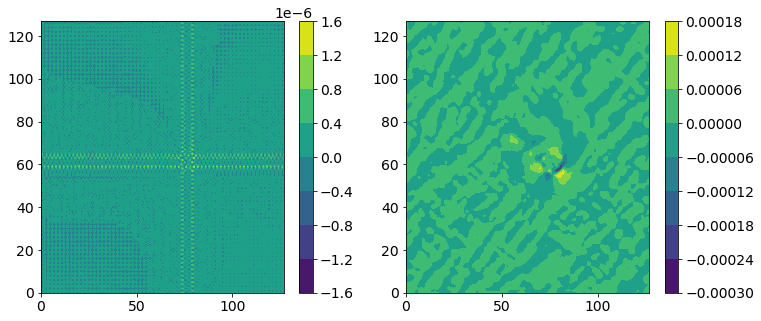

In [92]:
##run some diagnostics
##get scale component and compute rmse sprd sawtooth
##feature space diag
def divergence(X, dx):
    uk, vk = (grid2spec(X[:, :, 0]), grid2spec(X[:, :, 1]))
    ki, kj = get_scaled_wn(uk, dx)
    divk = 1j*(ki*uk + kj*vk)
    div = spec2grid(divk)
    return div

t = 1
plt.figure(figsize=(12,5))
ax = plt.subplot(121)
c = ax.contourf(divergence(Xb[:, :, :, 10, t], dx))
plt.colorbar(c)
ax = plt.subplot(122)
c = ax.contourf(divergence(X[:, :, :, 10, t], dx))
plt.colorbar(c)

In [93]:
def plot_summary(t):
    ##panel 1: true u wind maps
    ax[0].clear()
    u_contour = (-30, 30)  ##highlight these contours
    c = ax[0].contourf(Xt[:, :, 0, t].T, np.arange(-50, 51), cmap='bwr')
    ax[0].contour(Xt[:, :, 0, t].T, u_contour, colors='black', linewidths=3)
    ax[0].set_title('true u wind t={}h'.format(t))
    
    ##panel 2: ensemble spaghetti plots of highlighted contours
    ax[1].clear()
    cmap = [plt.cm.jet(x) for x in np.linspace(0, 1,nens)]
    for m in range(nens):
        ax[1].contour(X[:, :, 0, m, t].T, u_contour, colors=[cmap[m][0:3]])
    ax[1].contour(Xt[:, :, 0, t].T, u_contour, colors='black', linewidths=3)
    ax[1].set_title('ensemble spaghetti t={}h'.format(t))

    ##panel 3: power spectra
    ax[2].clear()
    wn, pwr = pwr_spec(Xt[:, :, :, t])
    ax[2].loglog(wn, pwr, color='black', linewidth=3, label='truth')
    wn, err_pwr = err_spec(X[:, :, :, :, t], Xt[:, :, :, t])
    ax[2].loglog(wn, err_pwr, color='red', linewidth=3, label='error')
    wn, sprd_pwr = sprd_spec(X[:, :, :, :, t])
    ax[2].loglog(wn, sprd_pwr, color='red', linestyle=':', linewidth=2, label='sprd')
    ax[2].legend()
    ax[2].set_title('power spectrum t={}h'.format(t))
    ax[2].set_ylim([1e-3, 1e2])

    ##panel 4: sawtooth graph (error time series)
    ax[3].clear()
    tt, rmse_st = sawtooth(rmse(Xb, Xt), rmse(X, Xt))
    tt, sprd_st = sawtooth(sprd(Xb), sprd(X))
    ax[3].plot(tt[0:2*t+2], rmse_st[0:2*t+2], color='red', linewidth=3)
    ax[3].plot(tt[0:2*t+2], sprd_st[0:2*t+2], color='red', linestyle=':', linewidth=2)
    ax[3].set_title('domain-avg rmse,sprd')
    ax[3].set_xlim([0, nt])
    ax[3].set_ylim([0, 5])
    ax[3].set_xlabel('t')
    return c

fig, ax = plt.subplots(1, 4, figsize=(20,5))
plt.rcParams.update({'font.size': 14})
plt.close()
anim = animation.FuncAnimation(fig, plot_summary, frames=nt, interval=300)
HTML(anim.to_html5_video())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the data range.
  del sys.path[0]


In [ ]:
t = 1
obs_err = Yo[:, :, :, t]- Xt[::obs_x_intv, ::obs_x_intv, :, t]
prior_err = np.mean(Xb[:, :, :, :, t], axis=3) - Xt[:, :, :, t]
post_err = np.mean(X[:, :, :, :, t], axis=3) - Xt[:, :, :, t]

plt.figure(figsize=(16,9))
ax = plt.subplot(231)
c = ax.contourf(obs_err[:, :, 0].T, cmap='PRGn')
plt.colorbar(c)
ax.set_title('obs error')

ax = plt.subplot(232)
c = ax.contourf(prior_err[:, :, 0].T, cmap='PRGn')
plt.colorbar(c)
ax.set_title('prior error')

ax = plt.subplot(233)
c = ax.contourf(post_err[:, :, 0].T, cmap='PRGn')
plt.colorbar(c)
ax.set_title('post error')

plt.figure(figsize=(8,6))
ax = plt.subplot(111)
wn, pwr = pwr_spec(Xt[:, :, :, t])
ax.loglog(wn, pwr, color='black', linewidth=3, label='truth')
wn, pwr = pwr_spec(obs_err)
ax.loglog(wn, pwr, color='green', linewidth=3, label='obs error')
wn, pwr = pwr_spec(prior_err)
ax.loglog(wn, pwr, color='red', linewidth=3, label='prior error')
wn, pwr = pwr_spec(post_err)
ax.loglog(wn, pwr, color='blue', linewidth=3, label='post error')
wn, pwr = sprd_spec(Xb[:, :, :, :, t])
ax.loglog(wn, pwr, color='red', linewidth=2, linestyle=':', label='prior sprd')
wn, pwr = sprd_spec(X[:, :, :, :, t])
ax.loglog(wn, pwr, color='blue', linewidth=2, linestyle=':', label='post sprd')
ax.set_xlim([0.8, 100])
ax.set_ylim([1e-3, 1e2])
ax.legend()
ax.set_title('spectrum')

##tuning parameters

testing param = 5
running filter update
   process scale component 1
testing param = 10
running filter update
   process scale component 1
testing param = 15
running filter update
   process scale component 1
testing param = 20
running filter update
   process scale component 1
testing param = 25
running filter update
   process scale component 1
testing param = 30
running filter update
   process scale component 1
testing param = 35
running filter update
   process scale component 1
testing param = 40
running filter update
   process scale component 1


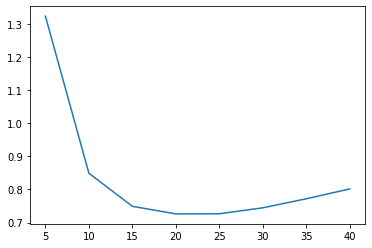

In [ ]:
t = 0
params = np.arange(5, 41, 5) ##for localization
rmse_out = np.zeros(len(params))
for p in range(params.size):
    print('testing param = {}'.format(params[p]))
    obs_err_std = 3
    ns = 1
    local_cutoff = params[p]*np.ones(ns)
    obs_err_infl = np.ones(ns)
    obs_thin = np.ones(ns).astype(int)

    ###run filter update
    print('running filter update')
    Xa = filter_update(Xb[:, :, :, :, t], Yo[:, t], Ymask[:, t], Yloc[:, :, t], filter_kind,
                       obs_err_std*obs_err_infl, obs_thin, local_cutoff, 
                       get_krange(ns, ni, nj, nobs), run_alignment)

    rmse_out[p] = rmse(Xa, Xt[:, :, :, t])
plt.figure()
plt.plot(params, rmse_out)